# Lab: Build Neural Networks via Pytorch

The purpose of this assignment is to learn how to build neural networks using PyTorch, focusing on both the theoretical and practical aspects of the process.

One key step involves passing the output of a regression model through the Sigmoid function. This operation transforms the raw output (often called the logit) into a probability value between 0 and 1, which represents the likelihood of an observation belonging to the positive class. 

This step is particularly important in binary classification tasks, as it allows us to interpret the model's predictions in probabilistic terms and enables subsequent evaluation using metrics such as accuracy or binary cross-entropy loss.

## Imports
<hr>

In [1]:
#Import Statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

#From Statements
from torchsummary import summary
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_regression, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

## Neural Network Classification
<hr>

### 1. Binary Classification

We will build a binary classification model using PyTorch. The output of the regression model will be passed through the Sigmoid function to convert it into a value between 0 and 1, representing the probability that an observation belongs to the positive class.

#### PyTorch Tensor

Please convert your input data, X (features) and y (labels), into PyTorch tensors so they can be used with PyTorch models.

X_t and y_t are created as tensors with the data type torch.float32, which is required for most machine learning tasks in PyTorch.

In [2]:
#Generate data
X, y = make_circles(n_samples=300, factor=0.5, noise=0.1, random_state=2020)

#Convert X and y from generated data into tensors of type float32
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32)

#### TensorDataset
Use PyTorch's TensorDataset and DataLoader to prepare the dataset for training, including batching and shuffling.

Requirements:

Combine X_t and y_t into a dataset using TensorDataset.

Use DataLoader to create batches of data for training. The batch size should be specified by the variable 45.
Enable shuffle=True in the DataLoader to randomize the order of data for each epoch.

In [3]:
#Make tensors into data set
dataset = TensorDataset(X_t, y_t)

#Define a batch size to use in batching
batchSize = 45

#Define a DataLoader with batching and shuffling
dataloader = DataLoader(dataset, batch_size=batchSize, shuffle=True)

#### Visualize your circular dataset

Visualize your circular dataset with the following requirements:

- The figure size should be set to 5×5.
- Data points with y = 0 should be marked in blue, and those with y = 1 should be marked in red.
- Both the x-axis and y-axis labels should have a font size of 14.

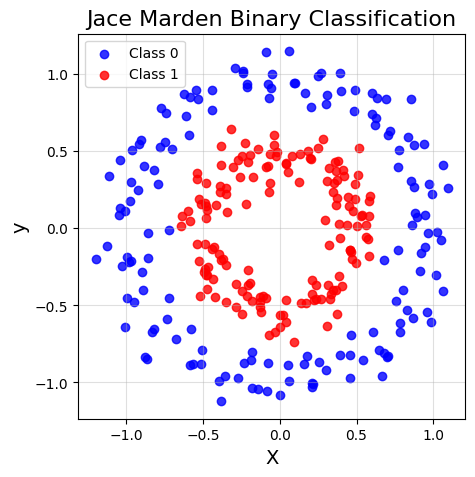

In [4]:
# Set figure size to be 5 x 5
plt.figure(figsize=(5, 5))

# Searched how best to mark 0s blue and 1s red
#Plot scatter points with color coded points
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue', label='Class 0', alpha=0.8)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='red', label='Class 1', alpha=0.8)

# Label x and y axis with font size 14
plt.xlabel("X", fontsize=14)
plt.ylabel("y", fontsize=14)

# Add Label and title
plt.title("Jace Marden Binary Classification", fontsize=16)

# Enable legend and grid, then show plot
plt.legend(loc="upper left")
plt.grid(alpha=0.4)
plt.show()

#### Create Neural Network 

Implement a neural network class for binary classification using PyTorch's nn.Module.

- Create a fully connected layer that maps the input features to the hidden layer.
- Use Relu as activation
- Create another fully connected layer
- Use Sigmoid


In [5]:
# Neural Network class for binary classification using PyTorch nn.Module 
class binaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.main = nn.Sequential(
            # Layer 1 Fully Connected mapping inputs to hidden
            nn.Linear(input_size, hidden_size),
            #ReLU as activation
            nn.ReLU(),
            #Another fully connected layer
            nn.Linear(hidden_size, output_size),
            #Sigmoid as activation
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.main(x)
        return out

#### Build trainer

Implement a simple training wrapper for a PyTorch network that handles the forward pass, backpropagation, and parameter updates for multiple epochs.

Training Process:

Epoch Loop: 
- Iterate over the specified number of epochs.

Batch Loop:
- Iterate over batches of X and y from the dataloader.
- Clear the gradients using optimizer.zero_grad().
- Perform a forward pass:
- Use the model to compute predictions (y_hat).
- Flatten the output to match the expected shape if necessary.
- Calculate the loss using criterion(y_hat, y).
- Perform backpropagation with loss to compute gradients.
- Update model parameters using optimizer.step().
- Accumulate the loss for the batch into a running total.

Logging:
- At the end of each epoch, compute and print the average loss over all batches if verbose is True.

In [6]:
def trainer(model, criterion, optimizer, dataloader, epochs=5, verbose=True, flatten=True):
    train_loss, valid_loss, valid_accuracy = [], [], []
    predicted_labels = []
    
    # Epoch Loop : Iterate over the specified number of epochs
    for epoch in range(epochs):
        # Default losses to 0 for batch
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_accuracy = 0

        #Set model mode to training
        model.train()
        # Batch Loop : Iterate over batches of X and y from the dataloader
        for X, y in dataloader:
            #Clear the gradients
            optimizer.zero_grad()
            #Perform a forward pass using the model to compute predictions, then flatten output to match expected shape
            if(flatten):
                y_hat = model(X).flatten()
            else:
                y = y.long()
                y_hat = model(X)
            #Calculate the loss
            loss = criterion(y_hat, y)
            #Perform backpropagation with loss to compute gradients
            loss.backward()
            #Update model parameters
            optimizer.step()
            #Accumulate the loss for the batch into a running total
            train_batch_loss += loss.item()

        #Track training loss
        train_loss.append(train_batch_loss / len(dataloader))

        #Validation mode
        model.eval()
        #Stop under-the-hood computation
        with torch.no_grad():
            all_preds = []
            all_labels = []
            
            for X, y in dataloader:
                #Forward pass to compute predictions
                if(flatten):
                    y_hat = model(X).flatten()
                else:
                    y_hat = model(X)
                #Apply sigmoid and classify outputs with threshold 0.5
                y_hat_labels = torch.sigmoid(y_hat) > 0.5

                #Add predictions and labels
                all_preds.append(y_hat_labels)
                all_labels.append(y)
                
                #Compute loss between predicted and actual
                loss = criterion(y_hat, y)
                #Accumulate validation batch loss
                valid_batch_loss += loss.item()
                #Compute validation accuracy
                valid_batch_accuracy += (y_hat_labels == y).type(torch.float32).mean().item()

            # Store final predictions after last epoch
            if epoch == epochs - 1:
                predicted_labels = torch.cat(all_preds).numpy()
                actual_labels = torch.cat(all_labels).numpy()
            
        #Compute avg validation loss for epoch
        valid_loss.append(valid_batch_loss / len(dataloader))
        #Compute avg validation accuracy for epoch
        valid_accuracy.append(valid_batch_accuracy / len(dataloader))

        #End of Epoch : Compute and Print average loss over all batches is verbose
        if verbose: 
            print(f"epoch: {epoch + 1}, loss: {train_batch_loss / len(dataloader):.4f}")
            print(f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}."
                 )
    
    results = {
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "valid_accuracy": valid_accuracy,
        "predicted_labels": predicted_labels,
        "actual_labels": actual_labels
    }
    return results  

Let's train the model:

In [7]:
# Set up model with 2 input, 6 hidden, and 1 output via binaryClassifier class
model = binaryClassifier(2, 6, 1)

#### Activation functions

We're going to using `ReLU` as our activation function(s) and `Adam` as our optimizer because these are what are currently, commonly used in practice. We are doing classification now so we'll need to use log loss (binary cross entropy) as our loss function:

$$f(w) = \sum_{x,y \in D} -y log(\hat{y}) - (1-y)log(1-\hat{y})$$

In PyTorch, the binary cross entropy loss criterion is `torch.nn.BCELoss`. The formula expects a "probability" which is why we add a Sigmoid function to the end of out network.

In [8]:
#Set a slow learning rate of 0.1
LEARNING_RATE = 0.1
# Binary Cross Entropy Loss Criterion
criterion = torch.nn.BCELoss()
#Use Adam as optimizer algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [9]:
# Call trainer funtion with model, criterion, optimizer, dataloader, epochs=30, verbose=True
results = trainer(model, criterion, optimizer, dataloader, epochs=30, verbose=True, flatten=True)

train_loss = results["train_loss"]
valid_loss = results["valid_loss"]
valid_accuracy = results["valid_accuracy"]
predicted_labels = results["predicted_labels"]
actual_labels = results["actual_labels"]

epoch: 1, loss: 0.6496
Train Loss: 0.650. Valid Loss: 0.588. Valid Accuracy: 0.50.
epoch: 2, loss: 0.5485
Train Loss: 0.548. Valid Loss: 0.479. Valid Accuracy: 0.50.
epoch: 3, loss: 0.4328
Train Loss: 0.433. Valid Loss: 0.359. Valid Accuracy: 0.50.
epoch: 4, loss: 0.3211
Train Loss: 0.321. Valid Loss: 0.260. Valid Accuracy: 0.50.
epoch: 5, loss: 0.2286
Train Loss: 0.229. Valid Loss: 0.189. Valid Accuracy: 0.49.
epoch: 6, loss: 0.1750
Train Loss: 0.175. Valid Loss: 0.144. Valid Accuracy: 0.50.
epoch: 7, loss: 0.1287
Train Loss: 0.129. Valid Loss: 0.116. Valid Accuracy: 0.50.
epoch: 8, loss: 0.1101
Train Loss: 0.110. Valid Loss: 0.096. Valid Accuracy: 0.50.
epoch: 9, loss: 0.0928
Train Loss: 0.093. Valid Loss: 0.082. Valid Accuracy: 0.50.
epoch: 10, loss: 0.0804
Train Loss: 0.080. Valid Loss: 0.071. Valid Accuracy: 0.50.
epoch: 11, loss: 0.0731
Train Loss: 0.073. Valid Loss: 0.065. Valid Accuracy: 0.50.
epoch: 12, loss: 0.0632
Train Loss: 0.063. Valid Loss: 0.060. Valid Accuracy: 0.51.
e

#### Visualize your results 

#### Part 1: Loss Curve

- Please plot the loss curve during training.
- Your graph needs to be labeled with x-axis, y-axis, and title.
- The title needs to include your first name.
- Your graph needs to have a legend and a grid.

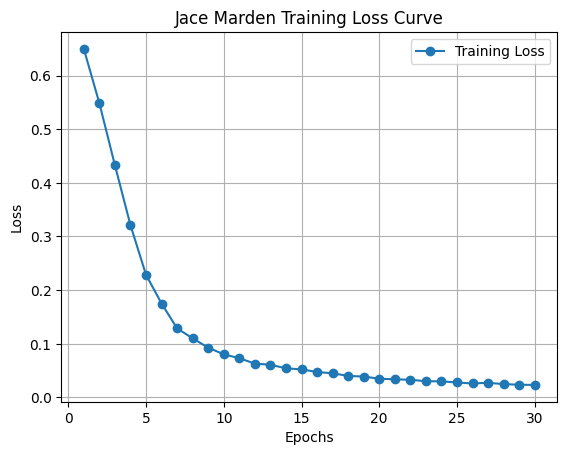

In [10]:
#Plot Training Loss Curve
plt.plot(range(1, len(results["train_loss"]) + 1), results["train_loss"], label="Training Loss", marker='o')

#Label x and y axis
plt.xlabel("Epochs")
plt.ylabel("Loss")
#Title with first name
plt.title("Jace Marden Training Loss Curve")

#Add legend and grid
plt.legend()
plt.grid()
plt.show()

### Part 2: Actual and predicted data 

- Please plot the Actual and predicted data after training.
- Your graph needs to be labeled with x-axis, y-axis, and title.
- The title needs to include your first name.
- Your graph needs to have a legend and a grid.

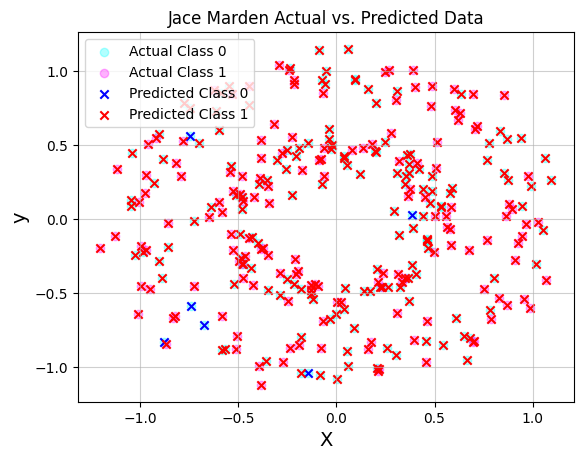

In [11]:
#Plot actual data points
plt.scatter(X_t.numpy()[actual_labels == 0, 0], X_t.numpy()[actual_labels == 0, 1], 
            color='cyan', label='Actual Class 0', alpha=0.3)
plt.scatter(X_t.numpy()[actual_labels == 1, 0], X_t.numpy()[actual_labels == 1, 1], 
            color='magenta', label='Actual Class 1', alpha=0.3)

# Plot predicted data points
plt.scatter(X_t.numpy()[predicted_labels == 0, 0], X_t.numpy()[predicted_labels == 0, 1], 
            color='blue', label='Predicted Class 0', marker='x')
plt.scatter(X_t.numpy()[predicted_labels == 1, 0], X_t.numpy()[predicted_labels == 1, 1], 
            color='red', label='Predicted Class 1', marker='x')

# Labels, title, legend, and grid
plt.xlabel("X", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Jace Marden Actual vs. Predicted Data")

plt.legend(loc="upper left")
plt.grid(alpha=0.6)
plt.show()

To be clear, our model is just outputting some number between -1 and +1 (we are applying Sigmoid in the model), so:
- To get the probabilities we would need to pass them through a Sigmoid;
- To get classes, we can apply some threshold (usually 0.5) to this probability.

For example, we would expect the point (0,0) to have a high probability and the point (-1,-1) to have a low probability:

In [12]:
prediction = model(X_t).flatten()
print(prediction)

tensor([9.6851e-01, 9.9783e-01, 9.9783e-01, 9.9783e-01, 1.5050e-07, 9.8088e-01,
        1.5354e-04, 9.9524e-01, 9.9761e-01, 9.9783e-01, 4.5417e-04, 9.9633e-01,
        9.9783e-01, 3.1993e-03, 4.0099e-04, 8.3515e-05, 1.1420e-02, 9.8018e-01,
        4.8113e-03, 2.7337e-04, 8.4256e-01, 9.0918e-01, 2.9076e-04, 9.9783e-01,
        9.7724e-01, 9.9295e-01, 9.9600e-01, 9.9373e-01, 9.9783e-01, 1.0217e-03,
        9.9383e-01, 3.6303e-02, 9.8630e-01, 7.4981e-04, 9.1605e-01, 9.5721e-01,
        2.6743e-06, 5.0699e-05, 9.7415e-03, 9.9783e-01, 9.9631e-01, 9.9783e-01,
        1.5286e-03, 9.9026e-01, 1.8742e-05, 6.7948e-03, 1.6629e-04, 9.9512e-01,
        3.3032e-05, 4.0054e-04, 1.5875e-05, 1.8271e-02, 1.9187e-03, 9.9622e-01,
        3.5000e-02, 9.9781e-01, 7.4622e-02, 9.9101e-01, 9.9783e-01, 1.9081e-04,
        8.7594e-01, 9.9783e-01, 9.9783e-01, 1.6384e-04, 9.3286e-01, 9.7781e-01,
        7.8110e-01, 9.4365e-01, 1.6514e-01, 3.6859e-06, 9.9478e-01, 4.7856e-03,
        2.2913e-03, 9.9783e-01, 3.2161e-

In [13]:
probability = (prediction >= 0.5).float()
print(probability)

tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
        0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 1., 0., 1., 0., 1., 1., 

In [14]:
classes = np.where(probability > 0.5, 1, 0)
print(classes)

[1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0
 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1
 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0
 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0
 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0
 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 1 0
 1 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1
 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 0
 0 0 1 0]


### 2. Multiclass Classification

For multiclass classification, we'll need the softmax function:

$$\sigma(\vec{z})_i=\frac{e^{z_i}}{\sum_{j=1}^{K}e^{z_j}}$$

It basically outputs probabilities for each class we wish to predict, and they all sum to 1. 

`torch.nn.CrossEntropyLoss` is a loss that combines a softmax with cross entropy loss. 

Let's try a 4-class classification problem using the following network:


In [15]:
X, y = make_blobs(n_samples=200, centers=4, center_box=(-1.2, 1.2), cluster_std=[0.15, 0.15, 0.15, 0.15], random_state=12345)

#Make X and y into tensors
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.long)

#Make tensors into data set
dataset2 = TensorDataset(X_t, y_t)

#Define a batch size to use in batching
batchSize = 45

#Define a DataLoader with batching and shuffling
dataloader2 = DataLoader(dataset2, batch_size=batchSize, shuffle=True)

In [16]:
class multiClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out = self.main(x)
        return out

#### Visualize your circular dataset

Visualize your circular dataset with the following requirements:

- The figure size should be set to 5×5.
- Both the x-axis and y-axis labels should have a font size of 14.

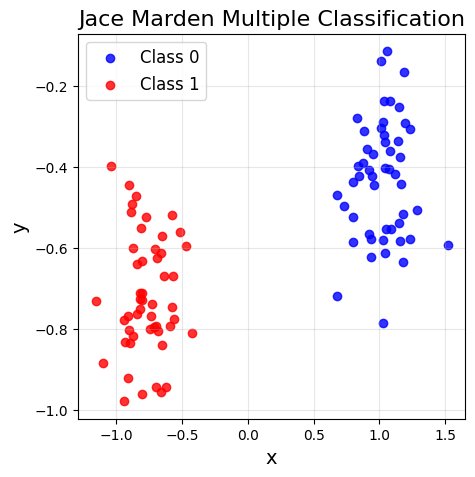

In [17]:
plt.figure(figsize=(5, 5))
# Plot each class
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue', label='Class 0', alpha=0.8)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='red', label='Class 1', alpha=0.8)

# Add Label and title
plt.title("Jace Marden Multiple Classification", fontsize=16)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)

plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

Let's train this model:

In [18]:
#Create a new trainer for 4 classes due to changes in sizes and need to flatten
def trainer2(model, criterion, optimizer, dataloader, epochs=5, verbose=True, flatten=True):
    train_loss, valid_loss, valid_accuracy = [], [], []
    predicted_labels = []
    
    # Epoch Loop : Iterate over the specified number of epochs
    for epoch in range(epochs):
        # Default losses to 0 for batch
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_accuracy = 0

        #Set model mode to training
        model.train()
        # Batch Loop : Iterate over batches of X and y from the dataloader
        for X, y in dataloader:
            #Clear the gradients
            optimizer.zero_grad()
            #Perform a forward pass using the model to compute predictions
            if(flatten):
                y_hat = model(X).flatten()
            else:
                y_hat = model(X)  # Output of shape [batch_size, 4]
                
            #Calculate the loss
            loss = criterion(y_hat, y)
            #Perform backpropagation with loss to compute gradients
            loss.backward()
            #Update model parameters
            optimizer.step()
            #Accumulate the loss for the batch into a running total
            train_batch_loss += loss.item()

        #Track training loss
        train_loss.append(train_batch_loss / len(dataloader))

        # Validation mode
        model.eval()
        # Stop under-the-hood computation
        with torch.no_grad():
            all_preds = []
            all_labels = []
            
            for X, y in dataloader:
                # Forward pass to compute predictions
                if(flatten):
                    y_hat = model(X).flatten()
                else:
                    y_hat = model(X)  # Output of shape [batch_size, 4]
                
                # Convert y_hat to predicted class indices (for multi-class classification)
                _, y_hat_labels = torch.max(y_hat, dim=1)  # Predicted class (0, 1, 2, or 3)
                
                # Add predictions and labels
                all_preds.append(y_hat_labels)
                all_labels.append(y)
                
                # Compute loss between predicted and actual
                loss = criterion(y_hat, y)
                # Accumulate validation batch loss
                valid_batch_loss += loss.item()
                # Compute validation accuracy (compare predicted class to true class)
                valid_batch_accuracy += (y_hat_labels == y).type(torch.float32).mean().item()

            # Store final predictions after last epoch
            if epoch == epochs - 1:
                predicted_labels = torch.cat(all_preds).numpy()
                actual_labels = torch.cat(all_labels).numpy()
            
        # Compute avg validation loss for epoch
        valid_loss.append(valid_batch_loss / len(dataloader))
        # Compute avg validation accuracy for epoch
        valid_accuracy.append(valid_batch_accuracy / len(dataloader))

        # End of Epoch : Compute and Print average loss over all batches if verbose
        if verbose: 
            print(f"epoch: {epoch + 1}, loss: {train_batch_loss / len(dataloader):.4f}")
            print(f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}."
                 )
    
    results = {
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "valid_accuracy": valid_accuracy,
        "predicted_labels": predicted_labels,
        "actual_labels": actual_labels
    }
    return results 

# model with 2 input layers, 6 hidden layers, and 4 output layers via multiClassifier class
model2 = multiClassifier(2, 6, 4)

#Set a slow learning rate of 0.2
LEARNING_RATE2 = 0.2
# CrossEntropyLoss
criterion2 = torch.nn.CrossEntropyLoss()
#Use Adam as optimizer algorithm
optimizer2 = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE2)

# Call trainer funtion with model, criterion, optimizer, dataloader, epochs, verbose
results2 = trainer2(model2, criterion2, optimizer2, dataloader2, epochs=10, verbose=True, flatten=False)

train_loss2 = results2["train_loss"]
valid_loss2 = results2["valid_loss"]
valid_accuracy2 = results2["valid_accuracy"]
predicted_labels2 = results2["predicted_labels"]
actual_labels2 = results2["actual_labels"]

print(f"Predicted : {predicted_labels2}")
print(f"Actual : {actual_labels2}")

epoch: 1, loss: 1.0367
Train Loss: 1.037. Valid Loss: 0.759. Valid Accuracy: 0.76.
epoch: 2, loss: 0.5791
Train Loss: 0.579. Valid Loss: 0.288. Valid Accuracy: 0.95.
epoch: 3, loss: 0.2043
Train Loss: 0.204. Valid Loss: 0.101. Valid Accuracy: 1.00.
epoch: 4, loss: 0.0686
Train Loss: 0.069. Valid Loss: 0.037. Valid Accuracy: 1.00.
epoch: 5, loss: 0.0271
Train Loss: 0.027. Valid Loss: 0.019. Valid Accuracy: 1.00.
epoch: 6, loss: 0.0171
Train Loss: 0.017. Valid Loss: 0.010. Valid Accuracy: 1.00.
epoch: 7, loss: 0.0080
Train Loss: 0.008. Valid Loss: 0.006. Valid Accuracy: 1.00.
epoch: 8, loss: 0.0052
Train Loss: 0.005. Valid Loss: 0.004. Valid Accuracy: 1.00.
epoch: 9, loss: 0.0039
Train Loss: 0.004. Valid Loss: 0.004. Valid Accuracy: 1.00.
epoch: 10, loss: 0.0043
Train Loss: 0.004. Valid Loss: 0.003. Valid Accuracy: 1.00.
Predicted : [0 2 3 3 0 3 2 3 2 1 0 0 2 3 3 0 2 2 3 3 3 2 1 2 1 1 0 2 2 0 2 1 3 2 1 1 2
 3 0 2 1 0 1 0 3 0 0 1 3 1 2 2 1 2 1 0 2 2 0 0 0 1 2 2 1 1 0 1 1 0 2 2 3 0
 1 0 3 

#### Visualize your results 

### Part 3: Accuracy Curve for 4 classes

- Please plot the Accuracy Curve during training.
- Your graph needs to be labeled with x-axis, y-axis, and title.
- The title needs to include your first name.
- Your graph needs to have a legend and a grid.

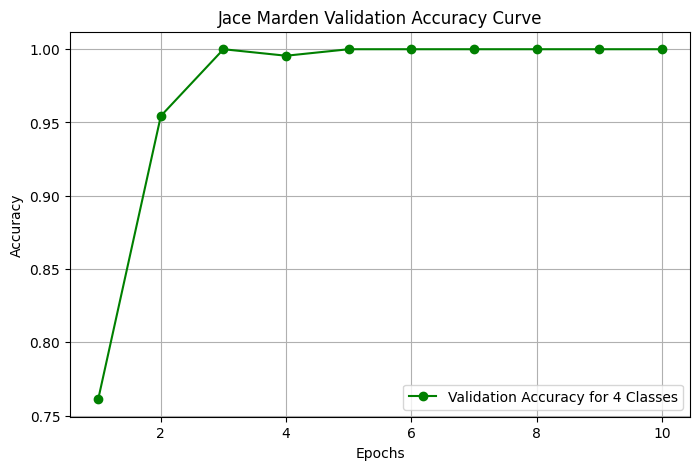

In [22]:
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(range(1, len(valid_accuracy2) + 1), valid_accuracy2, label="Validation Accuracy for 4 Classes", color='green', marker='o')
#plt.plot(range(1, len(valid_accuracy) + 1), valid_accuracy, label="Validation Accuracy for 2 Classes", color="blue", marker='x')
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Accuracy")  # Y-axis label
plt.title("Jace Marden Validation Accuracy Curve")  # Plot title
plt.legend()  # Add a legend
plt.grid()  # Add grid lines for better readability
plt.show()

### Part 4: Actual and predicted data for classes

- Please plot the Actual and predicted data after training.
- Your graph needs to be labeled with x-axis, y-axis, and title.
- The title needs to include your first name.
- Your graph needs to have a legend and a grid.

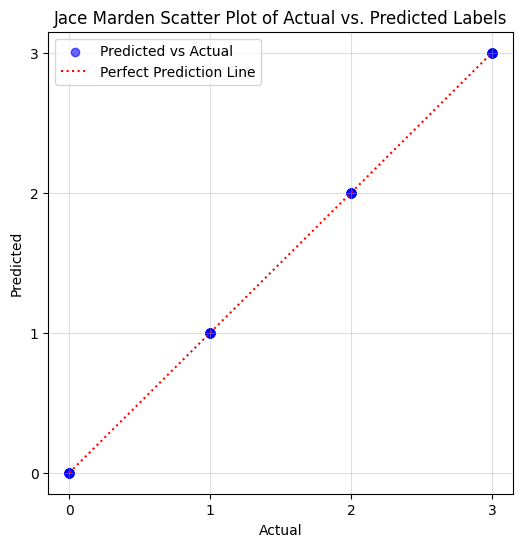

In [20]:
plt.figure(figsize=(6, 6))
#Plot each actual label againsts its prediction
#0-3 actual and 0-3 prediction
plt.scatter(actual_labels2, predicted_labels2, alpha=0.6, c="blue", label="Predicted vs Actual")


# Plot a diagonal line (y = x) for perfect predictions
plt.plot([0, 3], [0, 3], linestyle="dotted", color="red", label="Perfect Prediction Line")

# Labels and title
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.title("Jace Marden Scatter Plot of Actual vs. Predicted Labels")
plt.xticks(range(4))
plt.yticks(range(4))
plt.legend()
plt.grid(alpha=0.4)

plt.show()